# BidFlow 중간 보고서
## 보안 강화형 지능형 입찰 분석 시스템

**슬로건**: *Don't just Write, Find & Verify.*

**보고일**: 2026-02-11  
**작성팀**: AI6기 6팀

---

> 본 노트북은 BidFlow 프로젝트의 중간 진행 상황을 팀원 토의용으로 정리한 보고서입니다.  
> 상세 기획은 `AI6기_6팀_중급프로젝트_기획서.md`를 참조하세요.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 120

# 데이터 경로
DATA_DIR = Path('../data/experiments')
print('데이터 디렉토리:', DATA_DIR.resolve())

데이터 디렉토리: E:\Codeit\AI6_6team_Intermediate-Project\bidflow\data\experiments


---
## 1. 기획 개요

### 1.1 프로젝트 배경 및 목표

입찰 컨설턴트는 매일 수백 건의 공고와 수십 페이지의 RFP를 검토합니다.  
BidFlow는 이 과정을 **증거 기반(Evidence-First)** RAG 시스템으로 자동화합니다.

| 구분 | 내용 |
|:---|:---|
| **핵심 기능** | RFP 문서에서 30개 필수 항목(Compliance Matrix) 자동 추출 |
| **판정 방식** | 회사 프로필과 비교하여 Go/No-Go (GREEN/RED/GRAY) 판정 |
| **안전 철학** | 근거 부족 시 GRAY(판단 유보)로 안전 다운그레이드 |
| **보안** | 3-Rail 아키텍처 (Input/Process/Output) + OWASP 준수 |

### 1.2 핵심 설계 원칙 (불변 조건)

1. **근거 강제**: 모든 출력은 evidence(페이지/텍스트 offset, 표 셀 좌표) 포함
2. **단정 금지**: 근거 부족하면 GREEN/RED 대신 GRAY
3. **판정 분리**: LLM은 "추출/정리", 판정은 "룰 비교(Validator)"로 분리
4. **보안 KPI**: Garak Full + Red Teaming 기준 공격 성공률 < 5%, 슬롯 누락률 < 10%

### 1.3 요구사항 요약

| ID | 구분 | 요구사항 | 중요도 |
|:---:|:---:|:---|:---:|
| FR-01 | Ingest | RFP 파일(PDF, HWP) 업로드 | High |
| FR-02 | Parsing | 텍스트, 표, 메타데이터 파싱 (레이아웃 보존) | High |
| FR-03 | Extraction | 30개 필수 항목 추출 (Multi-step) | High |
| FR-04 | Validation | 회사 프로필 비교/판정 (Rule-based) | High |
| FR-05 | UI/UX | Streamlit 기반 결과 조회/근거 하이라이트 | High |
| FR-06 | Security | 프롬프트 인젝션 방어 + 민감정보 마스킹 | High |

> 상세 기획은 `AI6기_6팀_중급프로젝트_기획서.md` 참조

---
## 2. 시스템 아키텍처 및 기술 스택

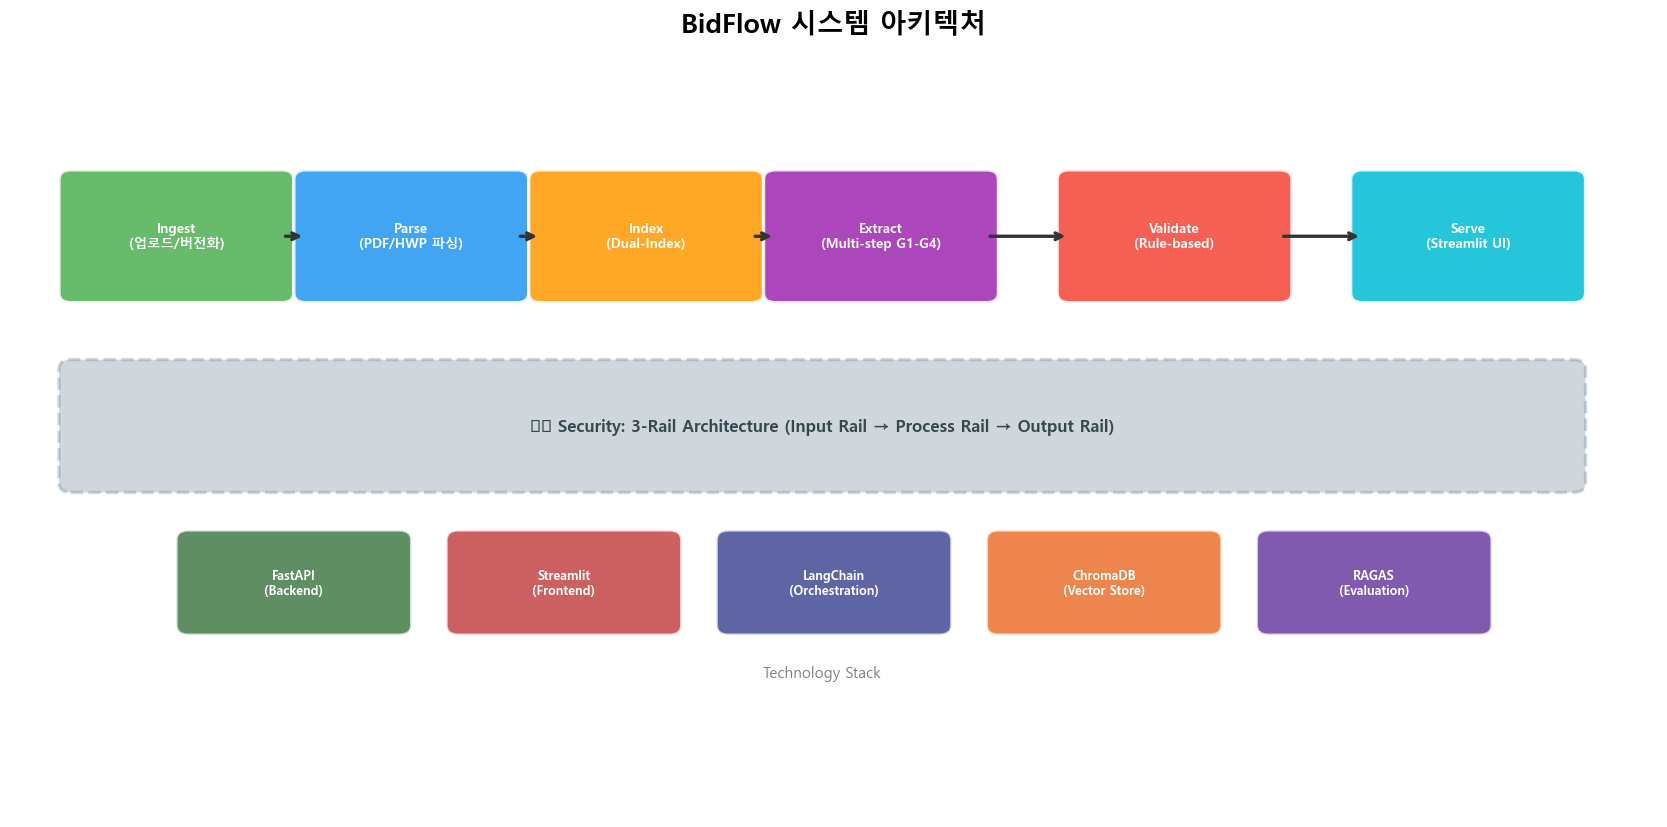

In [2]:
# 시스템 아키텍처 다이어그램
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.set_xlim(0, 14)
ax.set_ylim(0, 8)
ax.axis('off')
ax.set_title('BidFlow 시스템 아키텍처', fontsize=16, fontweight='bold', pad=15)

# 색상 정의
colors = {
    'ingest': '#4CAF50',
    'parse': '#2196F3',
    'index': '#FF9800',
    'extract': '#9C27B0',
    'validate': '#F44336',
    'serve': '#00BCD4',
    'security': '#607D8B'
}

# 파이프라인 박스 그리기
boxes = [
    (0.5, 5.5, 'Ingest\n(업로드/버전화)', colors['ingest']),
    (2.5, 5.5, 'Parse\n(PDF/HWP 파싱)', colors['parse']),
    (4.5, 5.5, 'Index\n(Dual-Index)', colors['index']),
    (6.5, 5.5, 'Extract\n(Multi-step G1-G4)', colors['extract']),
    (9.0, 5.5, 'Validate\n(Rule-based)', colors['validate']),
    (11.5, 5.5, 'Serve\n(Streamlit UI)', colors['serve']),
]

for x, y, label, color in boxes:
    rect = mpatches.FancyBboxPatch((x, y), 1.8, 1.2, boxstyle='round,pad=0.1',
                                   facecolor=color, alpha=0.85, edgecolor='white', linewidth=2)
    ax.add_patch(rect)
    ax.text(x + 0.9, y + 0.6, label, ha='center', va='center',
            fontsize=8, color='white', fontweight='bold')

# 화살표 그리기
arrow_style = dict(arrowstyle='->', color='#333', lw=2)
for i in range(len(boxes) - 1):
    x1 = boxes[i][0] + 1.8
    x2 = boxes[i+1][0]
    y = boxes[i][1] + 0.6
    ax.annotate('', xy=(x2, y), xytext=(x1, y), arrowprops=arrow_style)

# Security Layer (하단)
security_rect = mpatches.FancyBboxPatch((0.5, 3.5), 12.8, 1.2, boxstyle='round,pad=0.1',
                                         facecolor=colors['security'], alpha=0.3,
                                         edgecolor=colors['security'], linewidth=2, linestyle='--')
ax.add_patch(security_rect)
ax.text(6.9, 4.1, '🛡️ Security: 3-Rail Architecture (Input Rail → Process Rail → Output Rail)',
        ha='center', va='center', fontsize=10, color='#37474F', fontweight='bold')

# 기술 스택 (최하단)
tech_items = [
    (1.5, 2.0, 'FastAPI\n(Backend)', '#1B5E20'),
    (3.8, 2.0, 'Streamlit\n(Frontend)', '#B71C1C'),
    (6.1, 2.0, 'LangChain\n(Orchestration)', '#1A237E'),
    (8.4, 2.0, 'ChromaDB\n(Vector Store)', '#E65100'),
    (10.7, 2.0, 'RAGAS\n(Evaluation)', '#4A148C'),
]

for x, y, label, color in tech_items:
    rect = mpatches.FancyBboxPatch((x, y), 1.8, 0.9, boxstyle='round,pad=0.1',
                                   facecolor=color, alpha=0.7, edgecolor='white', linewidth=1.5)
    ax.add_patch(rect)
    ax.text(x + 0.9, y + 0.45, label, ha='center', va='center',
            fontsize=7.5, color='white', fontweight='bold')

ax.text(6.9, 1.5, 'Technology Stack', ha='center', va='center',
        fontsize=9, color='gray', style='italic')

plt.tight_layout()
plt.show()

---
## 3. 구현 완료 기능

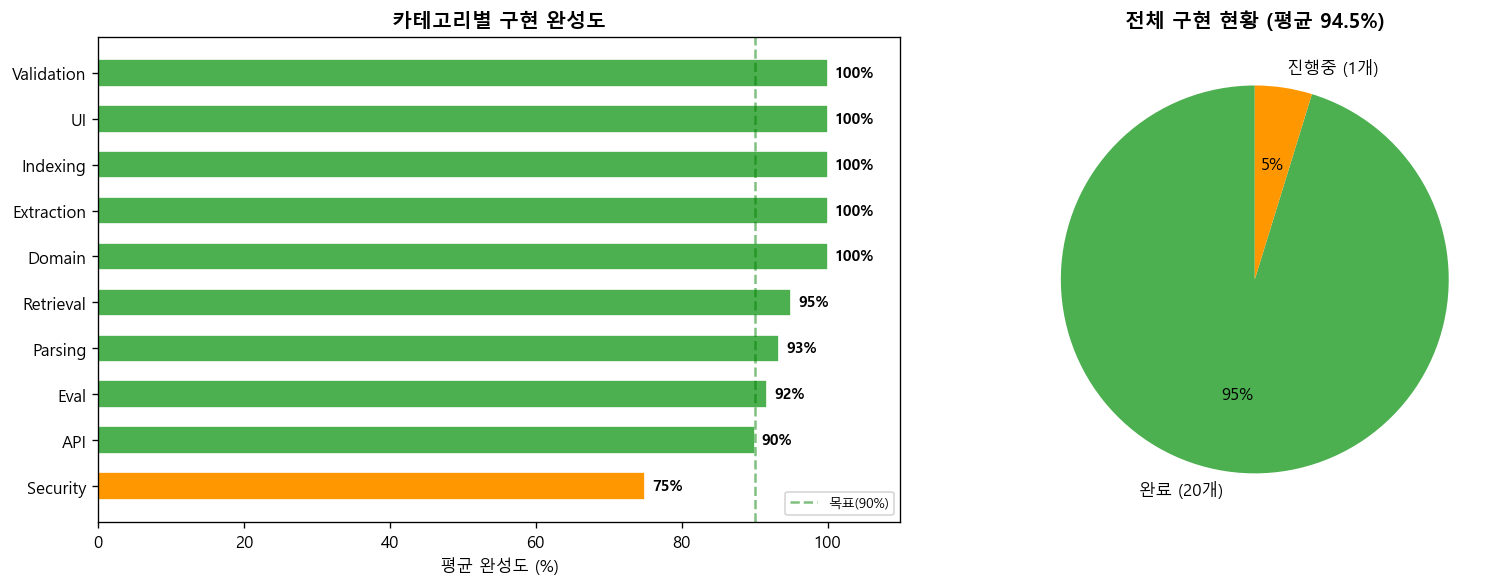


📋 전체 기능 구현 현황


,카테고리,기능,상태,완성도
0,Domain,30-슬롯 Compliance Matrix 정의 (G1~G4),완료,100
1,Domain,"Pydantic 데이터 모델 (Evidence, Slot, Matrix)",완료,100
2,Parsing,PDF 텍스트/표 파싱 (PyMuPDF + pdfplumber),완료,100
3,Parsing,HWP 포맷 파싱 기본 구조,완료,80
4,Parsing,보수적 전처리 (Normalization 중심),완료,100
5,Indexing,Dual-Index (Text + Table),완료,100
6,Indexing,BM25 키워드 + Vector 임베딩,완료,100
7,Retrieval,"Hybrid Search (BM25+Vector, RRF/Alpha)",완료,100
8,Retrieval,Cross-encoder Reranker (bge-reranker-v2-m3),완료,90
9,Extraction,Multi-step 추출 파이프라인 (G1→G4),완료,100


In [3]:
# 구현 현황 데이터
features = [
    # (카테고리, 기능, 상태, 완성도)
    ('Domain', '30-슬롯 Compliance Matrix 정의 (G1~G4)', '완료', 100),
    ('Domain', 'Pydantic 데이터 모델 (Evidence, Slot, Matrix)', '완료', 100),
    ('Parsing', 'PDF 텍스트/표 파싱 (PyMuPDF + pdfplumber)', '완료', 100),
    ('Parsing', 'HWP 포맷 파싱 기본 구조', '완료', 80),
    ('Parsing', '보수적 전처리 (Normalization 중심)', '완료', 100),
    ('Indexing', 'Dual-Index (Text + Table)', '완료', 100),
    ('Indexing', 'BM25 키워드 + Vector 임베딩', '완료', 100),
    ('Retrieval', 'Hybrid Search (BM25+Vector, RRF/Alpha)', '완료', 100),
    ('Retrieval', 'Cross-encoder Reranker (bge-reranker-v2-m3)', '완료', 90),
    ('Extraction', 'Multi-step 추출 파이프라인 (G1→G4)', '완료', 100),
    ('Extraction', '프롬프트 템플릿 (g1~g4, verbatim)', '완료', 100),
    ('Validation', 'Rule-based Validator 엔진', '완료', 100),
    ('Validation', 'GREEN/RED/GRAY 결정 트리', '완료', 100),
    ('Security', '3-Rail 보안 아키텍처 구조', '완료', 80),
    ('Security', 'PII 마스킹 모듈', '완료', 70),
    ('UI', 'Streamlit 멀티페이지 앱 (5개 페이지)', '완료', 100),
    ('UI', '근거 뷰어/프로필 에디터/판정 뱃지', '완료', 100),
    ('API', 'FastAPI 백엔드 라우터 구조', '완료', 90),
    ('Eval', 'RAGAS 평가 파이프라인', '완료', 100),
    ('Eval', 'Golden Testset (30문항)', '완료', 100),
    ('Eval', 'RAG 성능 최적화 실험 (EXP01~04v3)', '진행중', 75),
]

df_features = pd.DataFrame(features, columns=['카테고리', '기능', '상태', '완성도'])

# 카테고리별 평균 완성도 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 왼쪽: 카테고리별 완성도 바 차트
cat_avg = df_features.groupby('카테고리')['완성도'].mean().sort_values(ascending=True)
cat_colors = ['#4CAF50' if v >= 90 else '#FF9800' if v >= 70 else '#F44336' for v in cat_avg.values]
bars = axes[0].barh(cat_avg.index, cat_avg.values, color=cat_colors, edgecolor='white', height=0.6)
axes[0].set_xlim(0, 110)
axes[0].set_xlabel('평균 완성도 (%)')
axes[0].set_title('카테고리별 구현 완성도', fontweight='bold')
for bar, val in zip(bars, cat_avg.values):
    axes[0].text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.0f}%',
                va='center', fontsize=9, fontweight='bold')
axes[0].axvline(x=90, color='green', linestyle='--', alpha=0.5, label='목표(90%)')
axes[0].legend(fontsize=8)

# 오른쪽: 전체 진행 현황 파이 차트
completed = len(df_features[df_features['상태'] == '완료'])
in_progress = len(df_features[df_features['상태'] == '진행중'])
total = len(df_features)
overall_pct = df_features['완성도'].mean()

sizes = [completed, in_progress]
labels = [f'완료 ({completed}개)', f'진행중 ({in_progress}개)']
pie_colors = ['#4CAF50', '#FF9800']
wedges, texts, autotexts = axes[1].pie(sizes, labels=labels, colors=pie_colors,
                                        autopct='%1.0f%%', startangle=90,
                                        textprops={'fontsize': 10})
axes[1].set_title(f'전체 구현 현황 (평균 {overall_pct:.1f}%)', fontweight='bold')

plt.tight_layout()
plt.show()

# 기능 테이블 출력
print('\n📋 전체 기능 구현 현황')
print('=' * 80)
display(df_features.style.background_gradient(subset=['완성도'], cmap='RdYlGn', vmin=0, vmax=100))

---
## 4. RAG 성능 최적화 실험 현황

실험 계획서(`experiment_plan.md`)에 따라 체계적인 실험을 진행 중입니다.  
현재 **EXP04-v3**까지 완료했으며, 다음 단계(Exp-5 일반화 검증) 진행 전입니다.

### 4.1 실험 프레임워크

| 실험 | 변경 변수 | 핵심 지표 | 상태 |
|:---|:---|:---|:---:|
| **Exp-01** | Chunking + Table 보존 | Context Recall | 완료 |
| **Exp-02** | Retrieval 전략 (Alpha, Top-K) | CR, MRR, Latency | 완료 |
| **Exp-03** | Prompt Engineering | Faithfulness, KW Acc | 완료 |
| **Exp-04** | 통합 파이프라인 (Ablation) | KW Acc, Faith, CR | 완료 |
| **Exp-04v2** | Retrieval 아키텍처 고도화 | KW Acc, CR | 완료 |
| **Exp-04v3** | 매칭 품질 직접 개선 | KW Acc, Faith, CR | 완료 |
| **Exp-05** | 일반화 검증 | Best Config 검증 | **예정** |
| **Exp-06** | HWP 포맷 확장 | 파싱+추출 검증 | 예정 |

In [4]:
# 실험 결과 데이터 로드
def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

exp01 = load_json(DATA_DIR / 'exp01_report.json')
exp02 = load_json(DATA_DIR / 'exp02_report.json')
exp03 = load_json(DATA_DIR / 'exp03_report.json')
exp04 = load_json(DATA_DIR / 'exp04_report.json')
exp04v2 = load_json(DATA_DIR / 'exp04v2_report.json')
exp04v3 = load_json(DATA_DIR / 'exp04v3_report.json')

print('실험 데이터 로드 완료')
print(f'  Exp-01: {exp01["meta"]["date"][:10]}')
print(f'  Exp-02: {exp02["meta"]["date"][:10]}')
print(f'  Exp-03: {exp03["meta"]["date"][:10]}')
print(f'  Exp-04: {exp04["meta"]["date"][:10]}')
print(f'  Exp-04v2: {exp04v2["meta"]["date"][:10]}')
print(f'  Exp-04v3: {exp04v3["timestamp"][:10]}')

실험 데이터 로드 완료
  Exp-01: 2026-02-06
  Exp-02: 2026-02-09
  Exp-03: 2026-02-09
  Exp-04: 2026-02-10
  Exp-04v2: 2026-02-11
  Exp-04v3: 2026-02-11


### 4.2 실험 진행 경과: 핵심 지표 변화 추이

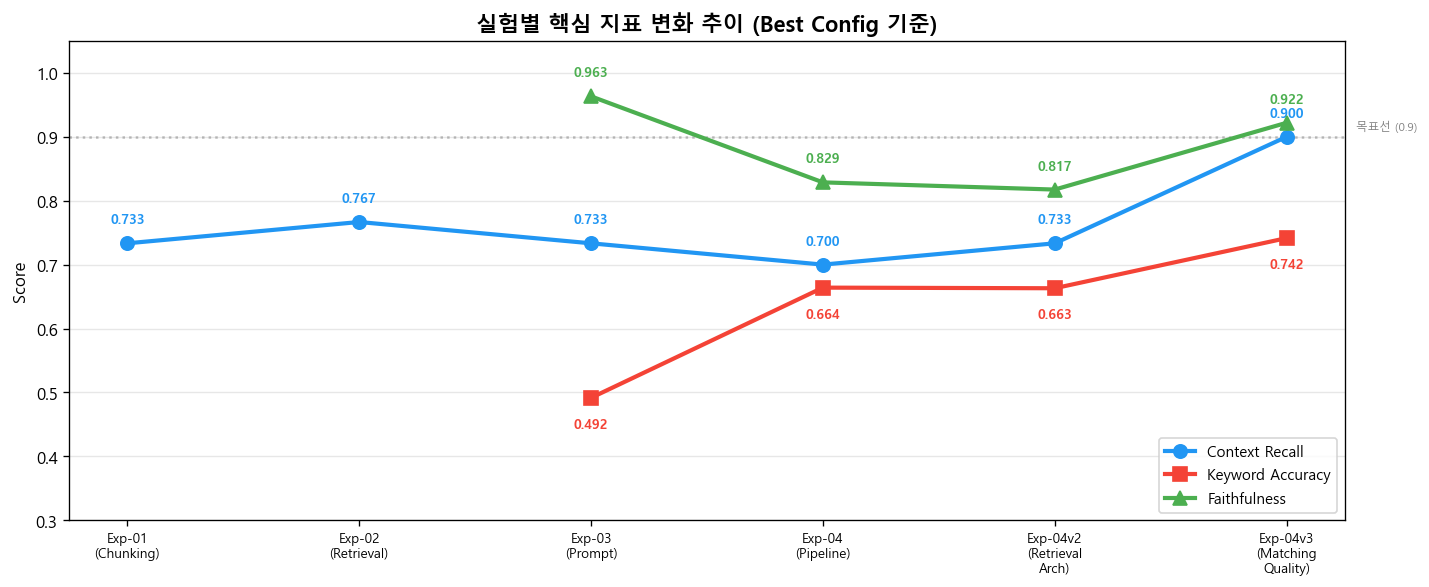


📊 핵심 인사이트:
  - Context Recall: 0.733 → 0.900 (Δ +0.167)
  - Keyword Accuracy: 0.492 → 0.742 (Δ +0.250)
  - Faithfulness: 0.963 → 0.922 (Δ -0.041)


In [5]:
# 실험별 Best Config 핵심 지표 추이
# 각 실험의 best 결과에서 주요 지표 추출
progression = [
    {
        'experiment': 'Exp-01\n(Chunking)',
        'context_recall': exp01['best_config']['context_recall'],
        'keyword_accuracy': None,  # Exp-01에서는 측정 안 함
        'faithfulness': None,
    },
    {
        'experiment': 'Exp-02\n(Retrieval)',
        'context_recall': exp02['best_config']['context_recall'],
        'keyword_accuracy': None,
        'faithfulness': None,
    },
    {
        'experiment': 'Exp-03\n(Prompt)',
        'context_recall': exp03['best_config']['context_recall'],
        'keyword_accuracy': exp03['best_config']['keyword_accuracy'],
        'faithfulness': exp03['best_config']['faithfulness'],
    },
    {
        'experiment': 'Exp-04\n(Pipeline)',
        'context_recall': exp04['best_config']['context_recall'],
        'keyword_accuracy': exp04['best_config']['keyword_accuracy'],
        'faithfulness': exp04['best_config']['faithfulness'],
    },
    {
        'experiment': 'Exp-04v2\n(Retrieval\nArch)',
        'context_recall': exp04v2['best_config']['context_recall'],
        'keyword_accuracy': exp04v2['best_config']['keyword_accuracy'],
        'faithfulness': exp04v2['best_config']['faithfulness'],
    },
    {
        'experiment': 'Exp-04v3\n(Matching\nQuality)',
        'context_recall': exp04v3['phase1_reranker']['best']['context_recall'],
        'keyword_accuracy': exp04v3['phase2_embedding']['best']['keyword_accuracy'],
        'faithfulness': exp04v3['phase1_reranker']['best']['faithfulness'],
    },
]

df_prog = pd.DataFrame(progression)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
x = range(len(df_prog))

# Context Recall
cr_vals = df_prog['context_recall'].values
ax.plot(x, cr_vals, 'o-', color='#2196F3', linewidth=2.5, markersize=8, label='Context Recall', zorder=5)
for i, v in enumerate(cr_vals):
    if v is not None:
        ax.annotate(f'{v:.3f}', (i, v), textcoords='offset points', xytext=(0, 12),
                    ha='center', fontsize=8, color='#2196F3', fontweight='bold')

# Keyword Accuracy
ka_vals = df_prog['keyword_accuracy'].values.astype(float)
mask_ka = ~np.isnan(ka_vals)
ax.plot(np.array(x)[mask_ka], ka_vals[mask_ka], 's-', color='#F44336', linewidth=2.5,
        markersize=8, label='Keyword Accuracy', zorder=5)
for i, v in enumerate(ka_vals):
    if not np.isnan(v):
        ax.annotate(f'{v:.3f}', (i, v), textcoords='offset points', xytext=(0, -18),
                    ha='center', fontsize=8, color='#F44336', fontweight='bold')

# Faithfulness
f_vals = df_prog['faithfulness'].values.astype(float)
mask_f = ~np.isnan(f_vals)
ax.plot(np.array(x)[mask_f], f_vals[mask_f], '^-', color='#4CAF50', linewidth=2.5,
        markersize=8, label='Faithfulness', zorder=5)
for i, v in enumerate(f_vals):
    if not np.isnan(v):
        ax.annotate(f'{v:.3f}', (i, v), textcoords='offset points', xytext=(0, 12),
                    ha='center', fontsize=8, color='#4CAF50', fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(df_prog['experiment'], fontsize=8)
ax.set_ylabel('Score')
ax.set_ylim(0.3, 1.05)
ax.set_title('실험별 핵심 지표 변화 추이 (Best Config 기준)', fontsize=13, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0.9, color='gray', linestyle=':', alpha=0.5)
ax.text(5.3, 0.91, '목표선 (0.9)', fontsize=7, color='gray')

plt.tight_layout()
plt.show()

print('\n📊 핵심 인사이트:')
print(f'  - Context Recall: {cr_vals[0]:.3f} → {cr_vals[-1]:.3f} (Δ +{cr_vals[-1]-cr_vals[0]:.3f})')
print(f'  - Keyword Accuracy: {ka_vals[mask_ka][0]:.3f} → {ka_vals[mask_ka][-1]:.3f} (Δ +{ka_vals[mask_ka][-1]-ka_vals[mask_ka][0]:.3f})')
print(f'  - Faithfulness: {f_vals[mask_f][0]:.3f} → {f_vals[mask_f][-1]:.3f} (Δ {f_vals[mask_f][-1]-f_vals[mask_f][0]:+.3f})')

### 4.3 EXP04-v3 상세 분석: 매칭 품질 직접 개선

EXP04-v3은 기존 실험들의 교훈을 바탕으로 **"후보 품질을 직접 올리자"**는 철학 전환을 적용한 실험입니다.

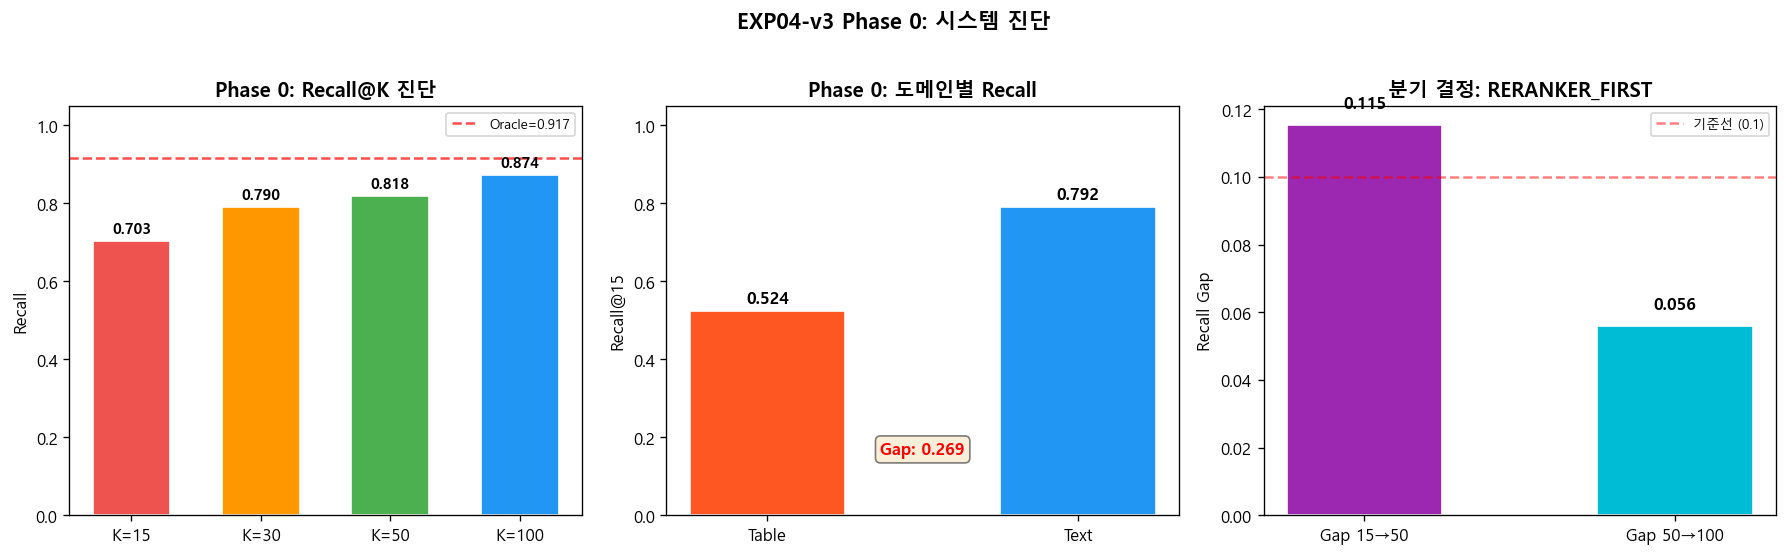


진단 결과 요약:
  Oracle Recall = 0.917 (인덱스에 정보 존재 확인)
  Recall@15 → @50 갭 = 0.115 (> 0.1이므로 Reranker 우선 적용 결정)
  Table 도메인 Recall이 Text보다 0.269 낮음 → 표 기반 질문이 어려움


In [6]:
# Phase 0: 진단 결과 시각화
diag = exp04v3['diagnostic']

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

# 1) Recall@K 분석
ks = [15, 30, 50, 100]
recalls = [diag['recall_at_k'][str(k)] for k in ks]
bars = axes[0].bar([f'K={k}' for k in ks], recalls, color=['#ef5350', '#FF9800', '#4CAF50', '#2196F3'],
                   edgecolor='white', width=0.6)
axes[0].axhline(y=diag['oracle_recall_mean'], color='red', linestyle='--', alpha=0.7, label=f'Oracle={diag["oracle_recall_mean"]:.3f}')
axes[0].set_ylim(0, 1.05)
axes[0].set_ylabel('Recall')
axes[0].set_title('Phase 0: Recall@K 진단', fontweight='bold')
for bar, val in zip(bars, recalls):
    axes[0].text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
                ha='center', fontsize=9, fontweight='bold')
axes[0].legend(fontsize=8)

# 2) Table vs Text Recall 비교
domain_data = {'Table': diag['table_recall_15'], 'Text': diag['text_recall_15']}
bars2 = axes[1].bar(domain_data.keys(), domain_data.values(),
                    color=['#FF5722', '#2196F3'], edgecolor='white', width=0.5)
axes[1].set_ylim(0, 1.05)
axes[1].set_ylabel('Recall@15')
axes[1].set_title('Phase 0: 도메인별 Recall', fontweight='bold')
for bar, val in zip(bars2, domain_data.values()):
    axes[1].text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
                ha='center', fontsize=10, fontweight='bold')
gap = domain_data['Text'] - domain_data['Table']
axes[1].text(0.5, 0.15, f'Gap: {gap:.3f}', ha='center', fontsize=10, color='red',
            transform=axes[1].transAxes, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3) 진단 분기 결정
decision_data = {
    'Gap 15→50': diag['gap_15_50'],
    'Gap 50→100': diag['gap_50_100'],
}
bars3 = axes[2].bar(decision_data.keys(), decision_data.values(),
                    color=['#9C27B0', '#00BCD4'], edgecolor='white', width=0.5)
axes[2].set_ylabel('Recall Gap')
axes[2].set_title(f'분기 결정: {diag["branch_decision"]}', fontweight='bold')
axes[2].axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='기준선 (0.1)')
for bar, val in zip(bars3, decision_data.values()):
    axes[2].text(bar.get_x() + bar.get_width()/2, val + 0.005, f'{val:.3f}',
                ha='center', fontsize=10, fontweight='bold')
axes[2].legend(fontsize=8)

plt.suptitle('EXP04-v3 Phase 0: 시스템 진단', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('\n진단 결과 요약:')
print(f'  Oracle Recall = {diag["oracle_recall_mean"]:.3f} (인덱스에 정보 존재 확인)')
print(f'  Recall@15 → @50 갭 = {diag["gap_15_50"]:.3f} (> 0.1이므로 Reranker 우선 적용 결정)')
print(f'  Table 도메인 Recall이 Text보다 {gap:.3f} 낮음 → 표 기반 질문이 어려움')

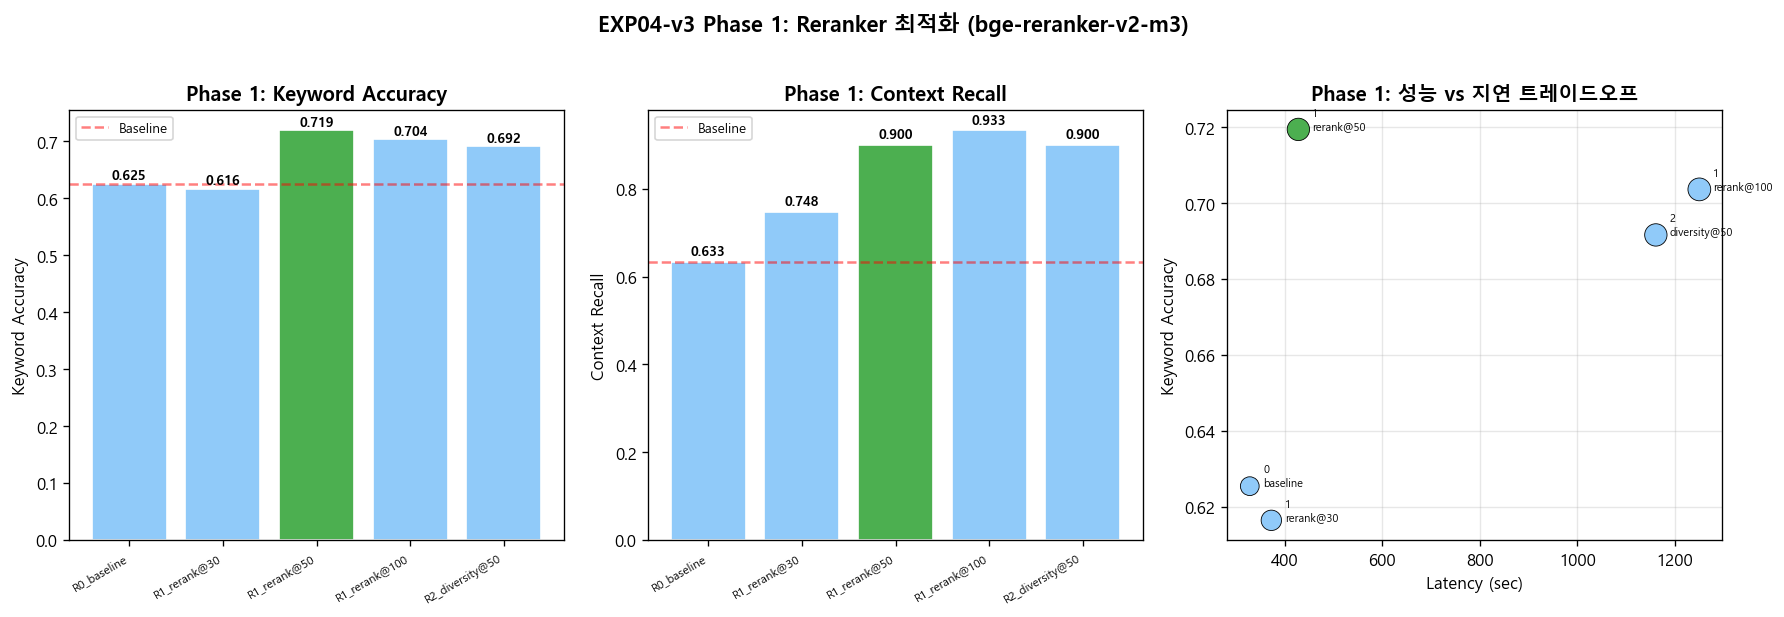


🏆 Best Config: R1_rerank@50 (Rerank-only (pool=50 → top-15))
   KW_Acc: 0.625 → 0.719 (Δ +0.094)
   CR:     0.633 → 0.900 (Δ +0.267)
   Faith:  0.825 → 0.922 (Δ +0.097)


In [7]:
# Phase 1: Reranker 설정별 비교
p1_configs = exp04v3['phase1_reranker']['configs']
df_p1 = pd.DataFrame(p1_configs)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 색상: best config 강조
best_config = exp04v3['phase1_reranker']['best']['config']
bar_colors = ['#4CAF50' if c == best_config else '#90CAF9' for c in df_p1['config']]

# 1) Keyword Accuracy
bars1 = axes[0].bar(range(len(df_p1)), df_p1['keyword_accuracy'], color=bar_colors, edgecolor='white')
axes[0].set_xticks(range(len(df_p1)))
axes[0].set_xticklabels(df_p1['config'], rotation=30, fontsize=7, ha='right')
axes[0].set_ylabel('Keyword Accuracy')
axes[0].set_title('Phase 1: Keyword Accuracy', fontweight='bold')
axes[0].axhline(y=0.6254, color='red', linestyle='--', alpha=0.5, label='Baseline')
for bar, val in zip(bars1, df_p1['keyword_accuracy']):
    axes[0].text(bar.get_x() + bar.get_width()/2, val + 0.008, f'{val:.3f}',
                ha='center', fontsize=8, fontweight='bold')
axes[0].legend(fontsize=8)

# 2) Context Recall
bars2 = axes[1].bar(range(len(df_p1)), df_p1['context_recall'], color=bar_colors, edgecolor='white')
axes[1].set_xticks(range(len(df_p1)))
axes[1].set_xticklabels(df_p1['config'], rotation=30, fontsize=7, ha='right')
axes[1].set_ylabel('Context Recall')
axes[1].set_title('Phase 1: Context Recall', fontweight='bold')
axes[1].axhline(y=0.6333, color='red', linestyle='--', alpha=0.5, label='Baseline')
for bar, val in zip(bars2, df_p1['context_recall']):
    axes[1].text(bar.get_x() + bar.get_width()/2, val + 0.015, f'{val:.3f}',
                ha='center', fontsize=8, fontweight='bold')
axes[1].legend(fontsize=8)

# 3) Latency vs 성능 트레이드오프
scatter = axes[2].scatter(df_p1['latency_sec'], df_p1['keyword_accuracy'],
                          s=df_p1['context_recall'] * 200, c=bar_colors,
                          edgecolors='black', linewidth=0.5, zorder=5)
for _, row in df_p1.iterrows():
    axes[2].annotate(row['config'].replace('R', '').replace('_', '\n'),
                     (row['latency_sec'], row['keyword_accuracy']),
                     textcoords='offset points', xytext=(8, 0), fontsize=6.5)
axes[2].set_xlabel('Latency (sec)')
axes[2].set_ylabel('Keyword Accuracy')
axes[2].set_title('Phase 1: 성능 vs 지연 트레이드오프', fontweight='bold')
axes[2].grid(alpha=0.3)

plt.suptitle('EXP04-v3 Phase 1: Reranker 최적화 (bge-reranker-v2-m3)', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

best = exp04v3['phase1_reranker']['best']
baseline = p1_configs[0]
print(f'\n🏆 Best Config: {best["config"]} ({best["desc"]})')
print(f'   KW_Acc: {baseline["keyword_accuracy"]:.3f} → {best["keyword_accuracy"]:.3f} (Δ +{best["keyword_accuracy"]-baseline["keyword_accuracy"]:.3f})')
print(f'   CR:     {baseline["context_recall"]:.3f} → {best["context_recall"]:.3f} (Δ +{best["context_recall"]-baseline["context_recall"]:.3f})')
print(f'   Faith:  {baseline["faithfulness"]:.3f} → {best["faithfulness"]:.3f} (Δ +{best["faithfulness"]-baseline["faithfulness"]:.3f})')

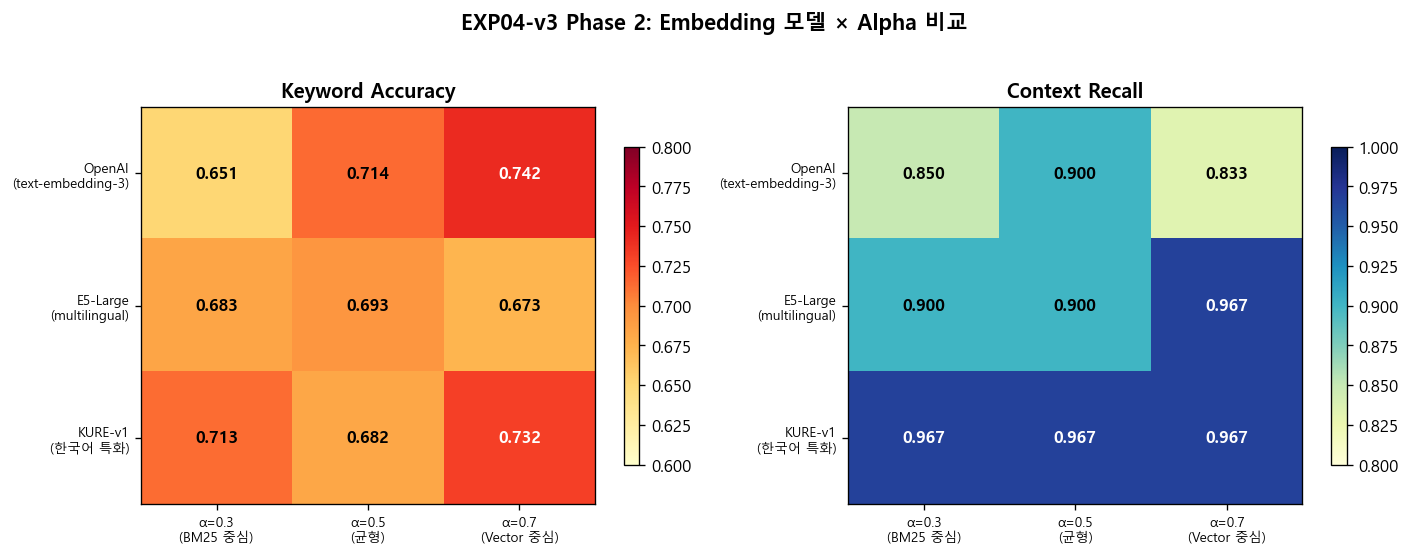


🏆 Best Config: E0_openai_a0.7 (Embedding=E0_openai, α=0.7)
   KW_Acc: 0.742
   CR:     0.833

💡 인사이트: KURE-v1은 CR이 가장 높지만(0.967), OpenAI α=0.7이 KW_Acc에서 우세(0.742)


In [8]:
# Phase 2: Embedding 모델 비교 (Alpha별 히트맵)
p2_results = exp04v3['phase2_embedding']['results']
df_p2 = pd.DataFrame(p2_results)

# 피벗 테이블 생성
embeddings = ['E0_openai', 'E1_e5_large', 'E2_kure_v1']
alphas = [0.3, 0.5, 0.7]

kw_matrix = np.zeros((3, 3))
cr_matrix = np.zeros((3, 3))
for _, row in df_p2.iterrows():
    ei = embeddings.index(row['embedding'])
    ai = alphas.index(row['alpha'])
    kw_matrix[ei][ai] = row['keyword_accuracy']
    cr_matrix[ei][ai] = row['context_recall']

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

emb_labels = ['OpenAI\n(text-embedding-3)', 'E5-Large\n(multilingual)', 'KURE-v1\n(한국어 특화)']
alpha_labels = ['α=0.3\n(BM25 중심)', 'α=0.5\n(균형)', 'α=0.7\n(Vector 중심)']

# KW Accuracy 히트맵
im1 = axes[0].imshow(kw_matrix, cmap='YlOrRd', vmin=0.6, vmax=0.8, aspect='auto')
axes[0].set_xticks(range(3))
axes[0].set_xticklabels(alpha_labels, fontsize=8)
axes[0].set_yticks(range(3))
axes[0].set_yticklabels(emb_labels, fontsize=8)
axes[0].set_title('Keyword Accuracy', fontweight='bold')
for i in range(3):
    for j in range(3):
        color = 'white' if kw_matrix[i][j] > 0.72 else 'black'
        axes[0].text(j, i, f'{kw_matrix[i][j]:.3f}', ha='center', va='center',
                    fontsize=10, fontweight='bold', color=color)
plt.colorbar(im1, ax=axes[0], shrink=0.8)

# Context Recall 히트맵
im2 = axes[1].imshow(cr_matrix, cmap='YlGnBu', vmin=0.8, vmax=1.0, aspect='auto')
axes[1].set_xticks(range(3))
axes[1].set_xticklabels(alpha_labels, fontsize=8)
axes[1].set_yticks(range(3))
axes[1].set_yticklabels(emb_labels, fontsize=8)
axes[1].set_title('Context Recall', fontweight='bold')
for i in range(3):
    for j in range(3):
        color = 'white' if cr_matrix[i][j] > 0.95 else 'black'
        axes[1].text(j, i, f'{cr_matrix[i][j]:.3f}', ha='center', va='center',
                    fontsize=10, fontweight='bold', color=color)
plt.colorbar(im2, ax=axes[1], shrink=0.8)

plt.suptitle('EXP04-v3 Phase 2: Embedding 모델 × Alpha 비교', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

best_p2 = exp04v3['phase2_embedding']['best']
print(f'\n🏆 Best Config: {best_p2["config"]} (Embedding={best_p2["embedding"]}, α={best_p2["alpha"]})')
print(f'   KW_Acc: {best_p2["keyword_accuracy"]:.3f}')
print(f'   CR:     {best_p2["context_recall"]:.3f}')
print(f'\n💡 인사이트: KURE-v1은 CR이 가장 높지만(0.967), OpenAI α=0.7이 KW_Acc에서 우세(0.742)')

In [9]:
# 전체 실험 결과 요약 테이블
summary_data = [
    {
        '실험': 'Exp-01 (Chunking)',
        '날짜': '02-06',
        'Best Config': 'chunk=500, table=layout',
        'Context Recall': 0.733,
        'KW Accuracy': '-',
        'Faithfulness': '-',
        '주요 발견': '레이아웃 기반 표 보존이 유리',
    },
    {
        '실험': 'Exp-02 (Retrieval)',
        '날짜': '02-09',
        'Best Config': 'α=0.5, top_k=15',
        'Context Recall': 0.767,
        'KW Accuracy': '-',
        'Faithfulness': '-',
        '주요 발견': 'Hybrid 검색이 단독 검색보다 우수',
    },
    {
        '실험': 'Exp-03 (Prompt)',
        '날짜': '02-09',
        'Best Config': 'zero_shot_ko',
        'Context Recall': 0.733,
        'KW Accuracy': 0.492,
        'Faithfulness': 0.963,
        '주요 발견': '한국어 프롬프트가 Faithfulness 최고',
    },
    {
        '실험': 'Exp-04 (Pipeline)',
        '날짜': '02-10',
        'Best Config': 'C_verbatim (Metadata+Verbatim)',
        'Context Recall': 0.700,
        'KW Accuracy': 0.664,
        'Faithfulness': 0.829,
        '주요 발견': 'Verbatim 프롬프트가 KW_Acc 대폭 개선',
    },
    {
        '실험': 'Exp-04v2 (Ret. Arch)',
        '날짜': '02-11',
        'Best Config': 'Baseline (chunk=500)',
        'Context Recall': 0.733,
        'KW Accuracy': 0.663,
        'Faithfulness': 0.817,
        '주요 발견': '아키텍처 복잡화가 오히려 성능 저하',
    },
    {
        '실험': 'Exp-04v3 (Matching)',
        '날짜': '02-11',
        'Best Config': 'Rerank@50 + OpenAI α=0.7',
        'Context Recall': 0.900,
        'KW Accuracy': 0.742,
        'Faithfulness': 0.922,
        '주요 발견': 'Reranker + Alpha 튜닝이 핵심',
    },
]

df_summary = pd.DataFrame(summary_data)
print('📊 전체 실험 결과 요약')
print('=' * 100)
display(df_summary)

📊 전체 실험 결과 요약


,실험,날짜,Best Config,Context Recall,KW Accuracy,Faithfulness,주요 발견
0,Exp-01 (Chunking),02-06,"chunk=500, table=layout",0.733,-,-,레이아웃 기반 표 보존이 유리
1,Exp-02 (Retrieval),02-09,"α=0.5, top_k=15",0.767,-,-,Hybrid 검색이 단독 검색보다 우수
2,Exp-03 (Prompt),02-09,zero_shot_ko,0.733,0.492,0.963,한국어 프롬프트가 Faithfulness 최고
3,Exp-04 (Pipeline),02-10,C_verbatim (Metadata+Verbatim),0.700,0.664,0.829,Verbatim 프롬프트가 KW_Acc 대폭 개선
4,Exp-04v2 (Ret. Arch),02-11,Baseline (chunk=500),0.733,0.663,0.817,아키텍처 복잡화가 오히려 성능 저하
5,Exp-04v3 (Matching),02-11,Rerank@50 + OpenAI α=0.7,0.900,0.742,0.922,Reranker + Alpha 튜닝이 핵심


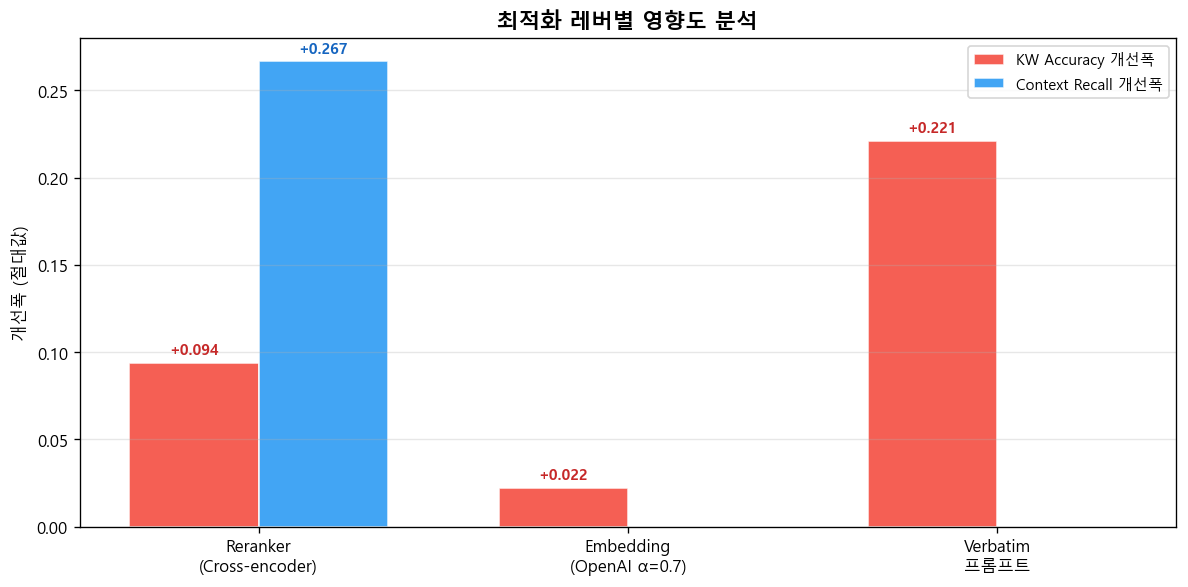


📌 영향도 순위:
  1순위: Reranker (KW_Acc +0.094, CR +0.267) - 가장 큰 영향
  2순위: Verbatim 프롬프트 (KW_Acc +0.221) - 추출 품질 개선
  3순위: Embedding α 튜닝 (KW_Acc +0.022) - 미세 조정


In [10]:
# EXP04-v3 컴포넌트별 영향도 분석
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# 각 최적화 레버의 영향도 (Exp-04v3 기준)
impact_data = {
    'Reranker\n(Cross-encoder)': {
        'KW_Acc 개선': 0.7194 - 0.6254,  # rerank@50 vs baseline
        'CR 개선': 0.9000 - 0.6333,
    },
    'Embedding\n(OpenAI α=0.7)': {
        'KW_Acc 개선': 0.7415 - 0.7194,  # best embedding vs rerank best
        'CR 개선': 0.0,  # CR은 동일 수준 유지
    },
    'Verbatim\n프롬프트': {
        'KW_Acc 개선': 0.6640 - 0.4430,  # from exp04 ablation
        'CR 개선': 0.0,
    },
}

components = list(impact_data.keys())
kw_impacts = [impact_data[c]['KW_Acc 개선'] for c in components]
cr_impacts = [impact_data[c]['CR 개선'] for c in components]

x = np.arange(len(components))
width = 0.35

bars1 = ax.bar(x - width/2, kw_impacts, width, label='KW Accuracy 개선폭',
               color='#F44336', edgecolor='white', alpha=0.85)
bars2 = ax.bar(x + width/2, cr_impacts, width, label='Context Recall 개선폭',
               color='#2196F3', edgecolor='white', alpha=0.85)

ax.set_xticks(x)
ax.set_xticklabels(components, fontsize=10)
ax.set_ylabel('개선폭 (절대값)')
ax.set_title('최적화 레버별 영향도 분석', fontsize=13, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3)

for bar in bars1:
    h = bar.get_height()
    if h > 0:
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.005, f'+{h:.3f}',
                ha='center', fontsize=9, fontweight='bold', color='#C62828')
for bar in bars2:
    h = bar.get_height()
    if h > 0:
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.005, f'+{h:.3f}',
                ha='center', fontsize=9, fontweight='bold', color='#1565C0')

plt.tight_layout()
plt.show()

print('\n📌 영향도 순위:')
print('  1순위: Reranker (KW_Acc +0.094, CR +0.267) - 가장 큰 영향')
print('  2순위: Verbatim 프롬프트 (KW_Acc +0.221) - 추출 품질 개선')
print('  3순위: Embedding α 튜닝 (KW_Acc +0.022) - 미세 조정')

### 4.4 현재 최적 설정 (Current Best Config)

| 컴포넌트 | 설정값 | 비고 |
|:---|:---|:---|
| **Chunking** | chunk_size=500, table=layout | Exp-01에서 확정 |
| **Retrieval** | Hybrid (BM25+Vector), top_k=15 | Exp-02에서 확정 |
| **Reranker** | bge-reranker-v2-m3, pool=50→top-15 | Exp-04v3 Phase 1 |
| **Embedding** | OpenAI (text-embedding-3), α=0.7 | Exp-04v3 Phase 2 |
| **Prompt** | Verbatim + Fact Sheet (한국어) | Exp-04에서 확정 |
| **LLM** | gpt-5-mini | 비용 최적화 |

**최종 성능 (EXP04-v3 기준)**:
- **Keyword Accuracy**: 0.742 (초기 0.492 대비 +50.8% 개선)
- **Context Recall**: 0.900 (초기 0.733 대비 +22.8% 개선)
- **Faithfulness**: 0.922 (목표 0.9 달성)

---
## 5. 남은 과제 (Enterprise Roadmap)

현재 MVP 단계에서 **다중 사용자 엔터프라이즈 서비스**로 확장하기 위한 로드맵입니다.  
상세 내용은 `enterprise_roadmap.md` 참조.

### 5.1 기능 고도화 로드맵

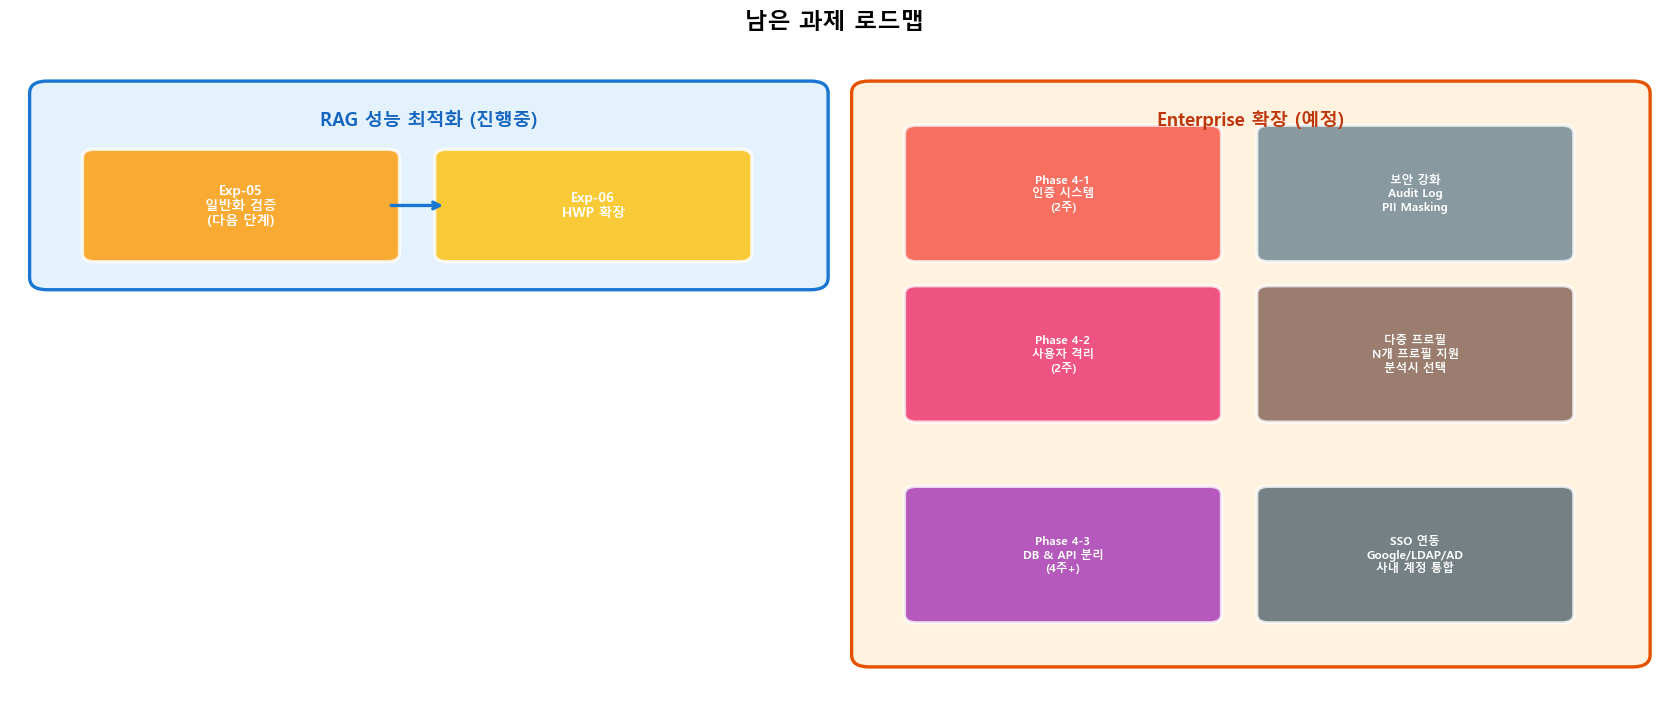

In [11]:
# Enterprise Roadmap 시각화
roadmap = [
    {
        'phase': 'Phase 4-1',
        'title': '인증 시스템',
        'duration': '2주',
        'items': ['Streamlit-Authenticator 도입', '로그인 화면 구현', '세션 제어'],
        'priority': 'High',
        'status': '예정',
    },
    {
        'phase': 'Phase 4-2',
        'title': '사용자 데이터 격리',
        'duration': '2주',
        'items': ['user_id 기반 스토리지 분리', '"내 문서함" UI', '팀 공유 저장소'],
        'priority': 'High',
        'status': '예정',
    },
    {
        'phase': 'Phase 4-3',
        'title': 'DB & API 분리',
        'duration': '4주+',
        'items': ['FastAPI 서버 분리', 'DB 스키마 설계 (SQLite/PostgreSQL)', '협업 기능 추가'],
        'priority': 'Medium',
        'status': '예정',
    },
]

# RAG 최적화 남은 실험
remaining_experiments = [
    {
        'phase': 'Exp-05',
        'title': '일반화 검증',
        'duration': '1주',
        'items': ['다른 도메인(건설, 정부R&D) RFP 테스트', 'Best Config 범용성 확인'],
        'priority': 'High',
        'status': '다음 단계',
    },
    {
        'phase': 'Exp-06',
        'title': 'HWP 포맷 확장',
        'duration': '1주',
        'items': ['HWP 파싱 검증', 'HWP 기반 RAG 성능 측정'],
        'priority': 'Medium',
        'status': '예정',
    },
]

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.set_xlim(0, 14)
ax.set_ylim(0, 8)
ax.axis('off')
ax.set_title('남은 과제 로드맵', fontsize=14, fontweight='bold', pad=15)

# RAG 최적화 영역
rag_rect = mpatches.FancyBboxPatch((0.3, 5.2), 6.5, 2.3, boxstyle='round,pad=0.15',
                                    facecolor='#E3F2FD', edgecolor='#1976D2', linewidth=2)
ax.add_patch(rag_rect)
ax.text(3.55, 7.1, 'RAG 성능 최적화 (진행중)', fontsize=11, fontweight='bold',
        ha='center', color='#1565C0')

# 실험 박스
exp_items = [
    (0.7, 5.5, 'Exp-05\n일반화 검증\n(다음 단계)', '#FF9800'),
    (3.7, 5.5, 'Exp-06\nHWP 확장', '#FFC107'),
]
for x_pos, y_pos, label, color in exp_items:
    rect = mpatches.FancyBboxPatch((x_pos, y_pos), 2.5, 1.2, boxstyle='round,pad=0.1',
                                   facecolor=color, alpha=0.8, edgecolor='white', linewidth=2)
    ax.add_patch(rect)
    ax.text(x_pos + 1.25, y_pos + 0.6, label, ha='center', va='center',
            fontsize=8, color='white', fontweight='bold')

# Enterprise 영역
ent_rect = mpatches.FancyBboxPatch((7.3, 0.5), 6.5, 7.0, boxstyle='round,pad=0.15',
                                    facecolor='#FFF3E0', edgecolor='#E65100', linewidth=2)
ax.add_patch(ent_rect)
ax.text(10.55, 7.1, 'Enterprise 확장 (예정)', fontsize=11, fontweight='bold',
        ha='center', color='#BF360C')

# Enterprise 박스
ent_items = [
    (7.7, 5.5, 'Phase 4-1\n인증 시스템\n(2주)', '#F44336'),
    (7.7, 3.5, 'Phase 4-2\n사용자 격리\n(2주)', '#E91E63'),
    (7.7, 1.0, 'Phase 4-3\nDB & API 분리\n(4주+)', '#9C27B0'),
    (10.7, 5.5, '보안 강화\nAudit Log\nPII Masking', '#607D8B'),
    (10.7, 3.5, '다중 프로필\nN개 프로필 지원\n분석시 선택', '#795548'),
    (10.7, 1.0, 'SSO 연동\nGoogle/LDAP/AD\n사내 계정 통합', '#455A64'),
]
for x_pos, y_pos, label, color in ent_items:
    rect = mpatches.FancyBboxPatch((x_pos, y_pos), 2.5, 1.5, boxstyle='round,pad=0.1',
                                   facecolor=color, alpha=0.75, edgecolor='white', linewidth=2)
    ax.add_patch(rect)
    ax.text(x_pos + 1.25, y_pos + 0.75, label, ha='center', va='center',
            fontsize=7, color='white', fontweight='bold')

# 화살표 (Exp-05 → Exp-06)
ax.annotate('', xy=(3.7, 6.1), xytext=(3.2, 6.1),
            arrowprops=dict(arrowstyle='->', color='#1976D2', lw=2))

plt.tight_layout()
plt.show()

### 5.2 Enterprise 확장 상세

| Phase | 기능 | 기간 | 핵심 변경 사항 |
|:---:|:---|:---:|:---|
| **4-1** | 인증 시스템 | 2주 | Streamlit-Authenticator 도입, 로그인 강제, 세션 관리 |
| **4-2** | 사용자 데이터 격리 | 2주 | user_id 기반 스토리지, "내 문서함" UI, DocumentStore 리팩토링 |
| **4-3** | DB & API 분리 | 4주+ | FastAPI 서버 분리, DB 스키마(User/RFP/Extraction), 협업 기능 |

**추가 보안 강화:**
- Audit Log (누가 언제 어떤 문서를 분석했는지)
- PII Masking 자동화 (업로드 시 개인정보 마스킹)
- RBAC (부서/직급별 접근 권한)

> 상세 내용은 `enterprise_roadmap.md` 참조

---
## 6. 현재 진행 상황 및 다음 단계

### 6.1 현재 상태 요약

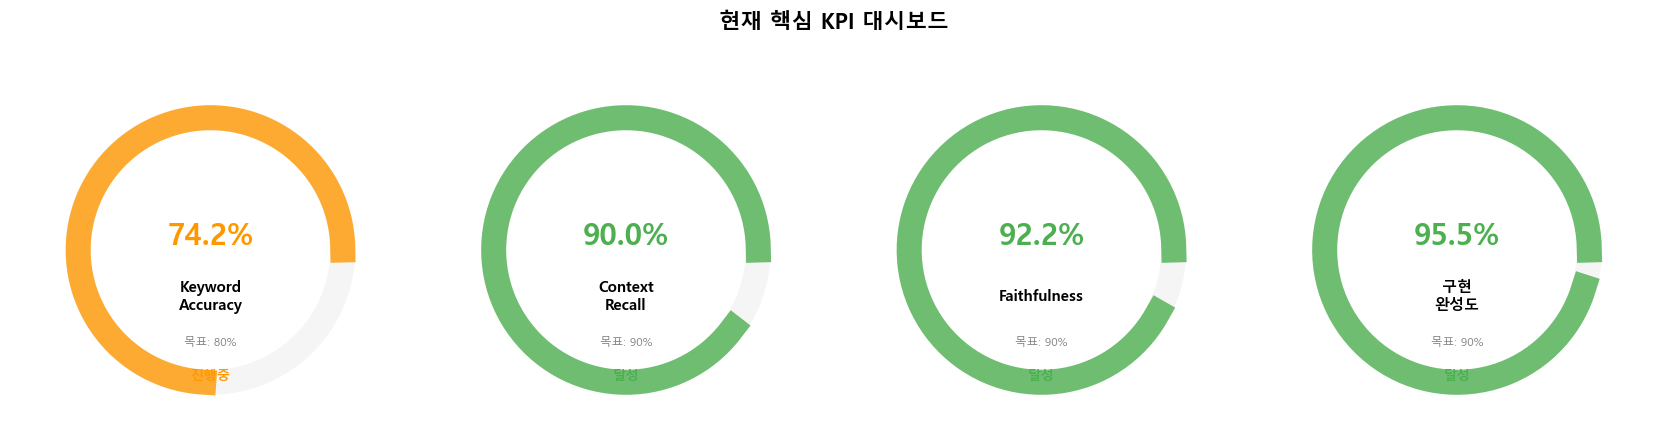

In [12]:
# 현재 상태 대시보드
fig, axes = plt.subplots(1, 4, figsize=(14, 3.5))

# KPI 게이지 스타일 시각화
kpis = [
    ('Keyword\nAccuracy', 0.742, 0.8, '#F44336'),
    ('Context\nRecall', 0.900, 0.9, '#4CAF50'),
    ('Faithfulness', 0.922, 0.9, '#4CAF50'),
    ('구현\n완성도', 0.955, 0.9, '#4CAF50'),
]

for ax, (label, value, target, color) in zip(axes, kpis):
    # 원형 프로그레스
    theta = np.linspace(0, 2 * np.pi * value, 100)
    theta_bg = np.linspace(0, 2 * np.pi, 100)

    ax.plot(np.cos(theta_bg), np.sin(theta_bg), color='#E0E0E0', linewidth=15, alpha=0.3)
    achieved_color = '#4CAF50' if value >= target else '#FF9800'
    ax.plot(np.cos(theta), np.sin(theta), color=achieved_color, linewidth=15, alpha=0.8)

    ax.text(0, 0.1, f'{value:.1%}', ha='center', va='center', fontsize=18, fontweight='bold',
           color=achieved_color)
    ax.text(0, -0.35, label, ha='center', va='center', fontsize=9, fontweight='bold')
    ax.text(0, -0.7, f'목표: {target:.0%}', ha='center', va='center', fontsize=7, color='gray')

    status = '달성' if value >= target else '진행중'
    status_color = '#4CAF50' if value >= target else '#FF9800'
    ax.text(0, -0.95, status, ha='center', va='center', fontsize=8,
           fontweight='bold', color=status_color)

    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.3, 1.3)
    ax.set_aspect('equal')
    ax.axis('off')

plt.suptitle('현재 핵심 KPI 대시보드', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 6.2 다음 단계 우선순위

| 우선순위 | 작업 | 설명 | 예상 기간 |
|:---:|:---|:---|:---:|
| **1** | Exp-05 일반화 검증 | 다른 도메인 RFP로 Best Config 범용성 확인 | 1주 |
| **2** | Exp-06 HWP 포맷 확장 | HWP 파서 검증 및 RAG 성능 측정 | 1주 |
| **3** | Table Integrity 고도화 | 표 무결성 점수 기반 GRAY 게이팅 정교화 | 1주 |
| **4** | Phase 4-1 인증 시스템 | Streamlit-Authenticator 도입 | 2주 |
| **5** | 보안 레드팀 테스트 | OWASP/Garak 기반 프롬프트 인젝션 방어 검증 | 1주 |

### 6.3 토의 안건

1. **Exp-05 대상 문서 선정**: 건설/정부R&D/IT 중 어떤 도메인 우선?
2. **Enterprise 로드맵 우선순위**: Phase 4-1(인증) vs RAG 최적화 완료 후 진행?
3. **Table 도메인 성능 개선**: 표 기반 질문 Recall이 여전히 낮음 (Text 대비 -0.269). 별도 대책 필요?
4. **KW Accuracy 목표치 조정**: 현재 0.742 → 목표 0.8 달성을 위한 추가 전략?

---
## 부록: 실험 환경 정보

| 항목 | 값 |
|:---|:---|
| **Golden Testset** | 30문항 (12개 카테고리: basic, schedule, budget, qualification, evaluation, ...) |
| **대상 문서** | 고려대학교 차세대 포털·학사 정보시스템 구축사업 RFP |
| **LLM** | gpt-5-mini (생성), gpt-4o-mini (유틸리티) |
| **Embedding** | OpenAI text-embedding-3 |
| **Reranker** | BAAI/bge-reranker-v2-m3 |
| **Vector DB** | ChromaDB |
| **평가 프레임워크** | RAGAS (Faithfulness, Context Recall, Answer Relevancy) |
| **실험 재현성** | seed=42 고정, JSON 산출물 버전 관리 |